# GOLD PRICE PREDICTION
sources :

https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/#:~:text=LSTMs%20are%20widely%20used%20for,the%20information%20that%20is%20not.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,InputLayer

In [126]:
df = pd.read_csv('../dataset/gold.csv')
dataset_length = len(df)

In [127]:
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,281.0,281.0,281.0,282.7,4,USD
1,2000-01-05,283.2,283.2,283.2,281.1,16,USD
2,2000-01-06,281.4,281.4,281.4,281.4,0,USD
3,2000-01-07,281.9,281.9,281.9,281.9,0,USD
4,2000-01-10,281.7,281.7,281.7,281.7,0,USD


# DATA PREPROCESSING : 
### Making it per month :

In [128]:
prices_in_month = {}
for i in range(dataset_length) :
    year_month = df.loc[i]["Date"][:7]
    try : ##if it exists in the dic
        prices_in_month[year_month] 
    except : ##else we create an empty list
        prices_in_month[year_month] = []
    prices_in_month[year_month].append(df.loc[i]["Close"])
    

In [129]:
# price_per_month = {}
# for k in prices_in_month :
#     avg = np.average(prices_in_month[k])
#     price_per_month[k] = [avg]

In [130]:
price_per_month = {
    "Date" : [],
    "Close": []
}
for k in prices_in_month :
    avg = np.average(prices_in_month[k])
    price_per_month["Date"].append(k) 
    price_per_month["Close"].append(avg) 
    

In [131]:
## make it a dataframe :
df1 = pd.DataFrame(price_per_month)
df1

,Date,Close
0,2000-01,284.894737
1,2000-02,300.090000
2,2000-03,285.956522
3,2000-04,279.784211
4,2000-05,274.936364
...,...,...
266,2022-03,1960.521739
267,2022-04,1944.180000
268,2022-05,1853.232609
269,2022-06,1838.936957


               Date        Close
Date                            
2000-01-01  2000-01   284.894737
2000-02-01  2000-02   300.090000
2000-03-01  2000-03   285.956522
2000-04-01  2000-04   279.784211
2000-05-01  2000-05   274.936364
...             ...          ...
2022-03-01  2022-03  1960.521739
2022-04-01  2022-04  1944.180000
2022-05-01  2022-05  1853.232609
2022-06-01  2022-06  1838.936957
2022-07-01  2022-07  1806.300000

[271 rows x 2 columns]


<AxesSubplot:xlabel='Date'>

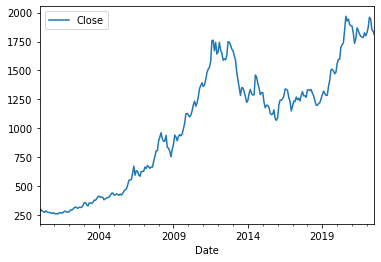

In [132]:
df1.index = pd.to_datetime(df1['Date'],format='%Y-%m')
print(df1)
df1.plot()

In [133]:
df_close = df1['Close']
df_close

Date
2000-01-01     284.894737
2000-02-01     300.090000
2000-03-01     285.956522
2000-04-01     279.784211
2000-05-01     274.936364
                 ...     
2022-03-01    1960.521739
2022-04-01    1944.180000
2022-05-01    1853.232609
2022-06-01    1838.936957
2022-07-01    1806.300000
Name: Close, Length: 271, dtype: float64

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled=scaler.fit_transform(np.array(df_close).reshape(-1,1))
df_scaled = pd.DataFrame(df_scaled,columns=['Close'])
df_close = df_scaled
df_close

,Close
0,0.013948
1,0.022848
2,0.014570
3,0.010955
4,0.008116
...,...
266,0.995366
267,0.985795
268,0.932527
269,0.924154


In [136]:
def to_X_Y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X),np.array(y)

In [137]:
WINDOW_SIZE = 5
X,y = to_X_Y(df_close,WINDOW_SIZE)
X.shape,y.shape

((266, 5, 1), (266,))

### split into training and test    

In [138]:
baseLen = X.shape[0]
trainingLen = int(baseLen*0.6)
valLen = int(baseLen*0.8)
x_train, y_train = X[:trainingLen],y[:trainingLen]
x_val, y_val = X[trainingLen:valLen],y[trainingLen:valLen]
x_test, y_test = X[valLen:],y[valLen:]

In [139]:
x_train.shape, y_train.shape ,x_val.shape, y_val.shape,x_test.shape, y_test.shape

((159, 5, 1), (159,), (53, 5, 1), (53,), (54, 5, 1), (54,))

# Model building

In [143]:
model = Sequential()

model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8,'relu'))
model.add(Dense(8,'linear'))


opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mean_squared_error',
    optimizer=opt,
    metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 64)                16896     
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 8)                 72        
                                                                 
Total params: 17,488
Trainable params: 17,488
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs = 5000
)

Epoch 1/5000
5/5 [==============================] - ETA: 0s - loss: 870118.2500 - accuracy: 0.0000e+00 - root_mean_squared_error: 932.8013 

In [122]:
test_predict=model.predict(x_test)
test_predict=scaler.inverse_transform(test_predict)
test_predict

2/2 [==============================] - 1s 5ms/step


array([[ 700.1296 , 1446.093  , 1286.144  , 1223.0896 ,  673.3682 ,
        1453.7001 , 1397.2512 ,  936.04175],
       [ 698.38184, 1440.0543 , 1277.6274 , 1217.9685 ,  672.38605,
        1445.2905 , 1390.2179 ,  928.55896],
       [ 701.91595, 1451.4417 , 1285.1615 , 1226.7756 ,  675.38995,
        1455.7454 , 1400.5785 ,  933.60516],
       [ 706.58203, 1466.4465 , 1296.3668 , 1238.508  ,  679.4838 ,
        1470.4902 , 1414.5349 ,  941.0001 ],
       [ 713.3581 , 1488.8916 , 1317.157  , 1256.5178 ,  684.5754 ,
        1494.8998 , 1437.028  ,  957.39514],
       [ 710.8416 , 1481.1538 , 1313.2174 , 1250.6409 ,  681.76843,
        1488.2335 , 1430.638  ,  956.41077],
       [ 705.63513, 1464.9913 , 1304.035  , 1238.2715 ,  676.20496,
        1473.7893 , 1416.8955 ,  953.0036 ],
       [ 698.0417 , 1441.1388 , 1289.7849 , 1219.9604 ,  668.60004,
        1452.3092 , 1396.1678 ,  946.2349 ],
       [ 686.33636, 1403.5128 , 1262.0459 , 1190.6227 ,  658.2989 ,
        1415.6881 , 1361.304

In [124]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,test_predict[:,0]))

816.0770135392261